<a href="https://colab.research.google.com/github/hiroalchem/data_science_lecture_2023/blob/main/Day5_20230309_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 今日の取り組み   
今日はYOLOv5を用いた基本的な物体検出を行ってみます   
今回は[こちら](https://public.roboflow.com/object-detection/bccd)のpublicなdatasetを使用します


# 0. 準備
## 0-1: 必要なデータのダウンロード


In [3]:
%cd /content
!curl -L "https://public.roboflow.com/ds/9iyNSXKJyb?key=PdEmmZM9Mz" > Day5.zip; unzip -d Day5 Day5.zip; rm Day5.zip
%cd Day5

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   4767      0 --:--:-- --:--:-- --:--:--  4742
100 12.7M  100 12.7M    0     0  33.9M      0 --:--:-- --:--:-- --:--:-- 33.9M
Archive:  Day5.zip
 extracting: Day5/README.dataset.txt  
 extracting: Day5/README.roboflow.txt  
 extracting: Day5/data.yaml          
   creating: Day5/test/
   creating: Day5/test/images/
 extracting: Day5/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg  
 extracting: Day5/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg  
 extracting: Day5/test/images/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg  
 extracting: Day5/test/images/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg  
 extracting: Day5/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg  
 extracting: Day5/t

train, valid, testそれぞれのフォルダとdata.yamlが今回使用するものです   
Day5    
&emsp;  |- train   
&emsp;  |- valid   
&emsp;  |- test   
&emsp;  |- data.yaml

## 0-2: 必要なライブラリをインストールし、インポートします。
 

In [4]:
# /content　に移動します
%cd /content

/content


In [5]:
# YOLOv5のリポジトリをcloneします。
!git clone https://github.com/ultralytics/yolov5

# リポジトリの中に移動
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15291, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 15291 (delta 0), reused 1 (delta 0), pack-reused 15287
Receiving objects: 100% (15291/15291), 14.19 MiB | 30.54 MiB/s, done.
Resolving deltas: 100% (10483/10483), done.
/content/yolov5


In [6]:
# 必要なライブラリをrequirements.txtを参照してインストールします。
# requirements.txtとは、リポジトリで必要なライブラリをまとめておいてくれているテキストファイルです。
%pip install -qr requirements.txt

# 必要なライブラリをimportします。

import torch
import os
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.
Setup complete. Using torch 1.13.1+cu116 (Tesla T4)


# 1. データと設定ファイルの確認

1-1: まず画像とアノテーションを確認します

In [7]:
# 学習用フォルダ内の画像フォルダとラベルフォルダをpathlib形式で取得しておきます
image_dir = Path('/content/Day5/train/images')
label_dir = Path('/content/Day5/train/labels')

# 画像パスをリストで取得しておきます
image_path_list = sorted(list(image_dir.glob('./*.jpg')))

#最初の5ファイルを出力
print(image_path_list[:5])

[PosixPath('/content/Day5/train/images/BloodImage_00001_jpg.rf.1a3206b15602db1d97193162a50bd001.jpg'), PosixPath('/content/Day5/train/images/BloodImage_00001_jpg.rf.26d17ca3eb24797053eee4e03545a917.jpg'), PosixPath('/content/Day5/train/images/BloodImage_00001_jpg.rf.3f768de1133398b7558743883a808be7.jpg'), PosixPath('/content/Day5/train/images/BloodImage_00002_jpg.rf.3f628ac8c9a3cccac2926e36a29d7eb5.jpg'), PosixPath('/content/Day5/train/images/BloodImage_00002_jpg.rf.72d4182864da81e2fc804f5382965abc.jpg')]


In [8]:
# いくつか必要な関数を作っておきます

# xywhをxyxyに変換する関数
def xywh2xyxy(xywh):
  x1 = xywh[0] - xywh[2]/2
  y1 = xywh[1] - xywh[3]/2
  x2 = x1 + xywh[2]
  y2 = y1 + xywh[3]
  return x1, y1, x2, y2

# 画像パスとラベルフォルダのパスを渡すとboxを描画して表示してくれる関数
def draw_box(image_path, label_dir):
  # クラスごとに色を割り当てるためのリストを作っておきます
  colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
  # ラベルのパスの取得
  label_path = label_dir / image_path.with_suffix('.txt').name

  # 画像を読み込んでサイズを取得しておきます
  im = Image.open(image_path)
  width, height = im.size

  # 描画するオブジェクトの生成
  draw = ImageDraw.Draw(im)

  # テキストファイルを1行ずつ読み込む
  with open(label_path, 'r') as f:
      for line in f.readlines():
        label, x, y, w, h = line.split(' ')
        # 端点に変換
        x1, y1, x2, y2 = xywh2xyxy((float(x), float(y), float(w), float(h)))
        # 矩形を書き込みます
        # 座標は0~1になっているので、画像の縦横サイズをかけるのを忘れずに
        # labelの値から色を割り当てます
        draw.rectangle((x1*width, y1*height, x2*width, y2*height), outline=colors[int(label)], width=3)

  # 全ての行を読んだら表示
  plt.imshow(im)


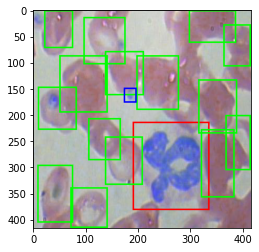

In [15]:
# 画像を確認してみます
draw_box(image_path_list[8], label_dir)

data.yamlの中のパスを以下に変更   
train: /content/Day5/train/images   
val: /content/Day5/valid/images   

In [17]:
# 学習をします
# 画像サイズは 320, バッチサイズ 2, Day5内のdata.yamlを参照, yolov5sを学習, エポックは50にしてみます。
!python train.py --img 320 --batch 2 --epochs 50 --data /content/Day5/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/Day5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=2, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, h

In [18]:
# val.pyで評価ができます。
# runs/train/にexpフォルダができています。その中で最高の性能であるbest.ptを選択します。

!python val.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 320 --data /content/Day5/data.yaml

val: data=/content/Day5/data.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/Day5/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100% 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 3/3 [00:05<00:00,  1.72s/it]
                   all         73        967      0.841      0.923      0.921      0.639
             Platelets         73         76      0.811      0.905      0.883      0.476
                   RBC 

In [19]:
# --task test とすることでテストデータも評価できます。
# data.yaml に test: /content/Day5/test/images の記述を追記します

!python val.py --task test --weights /content/yolov5/runs/train/exp/weights/best.pt --img 320 --data /content/Day5/data.yaml

val: data=/content/Day5/data.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/Day5/test/labels... 36 images, 0 backgrounds, 0 corrupt: 100% 36/36 [00:00<00:00, 556.32it/s]
test: New cache created: /content/Day5/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 2/2 [00:01<00:00,  1.37it/s]
                   all         36        471      0.858      0.872      0.896      0.608
             Platelets         36         36      0

In [20]:
# 検出結果を保存するにはdetect.pyを使用します。
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 320 --source  /content/Day5/test/images 

detect: weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], source=/content/Day5/test/images, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-117-g85f6019 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/36 /content/Day5/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg: 320x320 2 Plateletss, 32 RBCs, 1 WBC, 7.6ms
image 2/36 /content/Day5/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg: 320x320 4 Plateletss, 21 RBCs, 2 WBCs, 7.8ms
image 3/36 /content/Day5/test/images

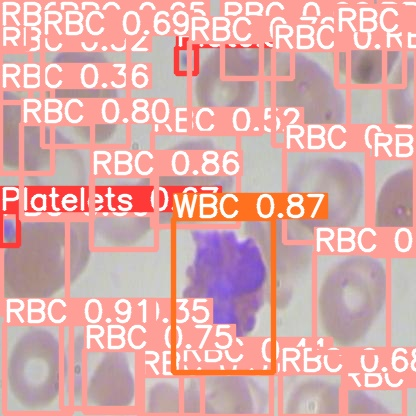

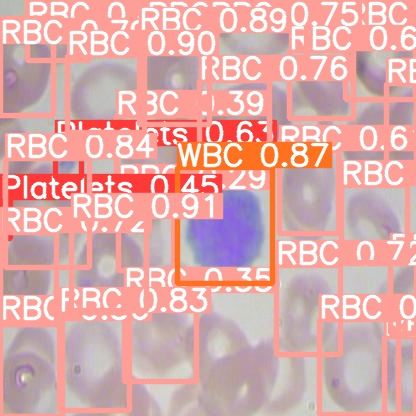

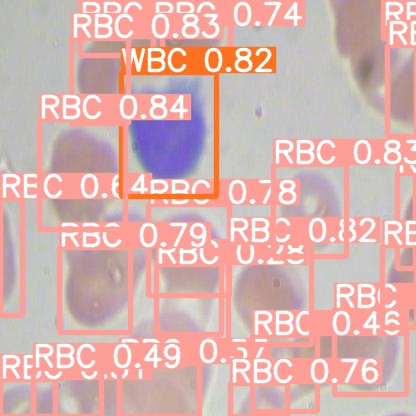

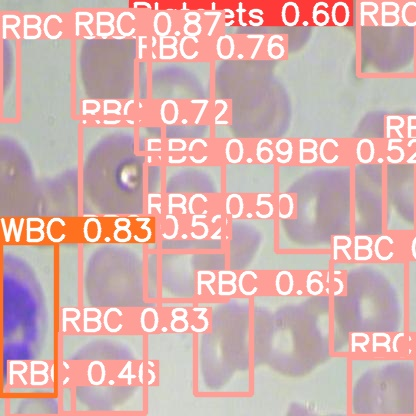

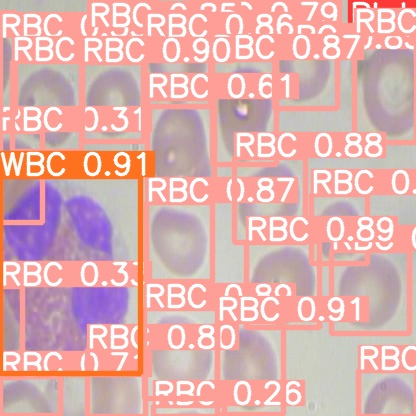

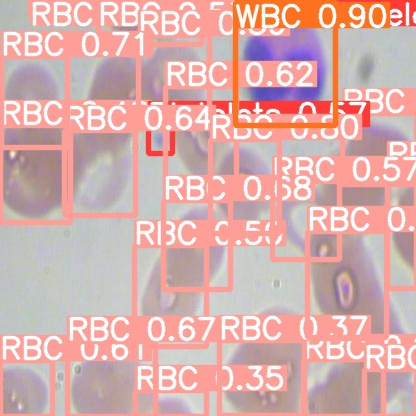

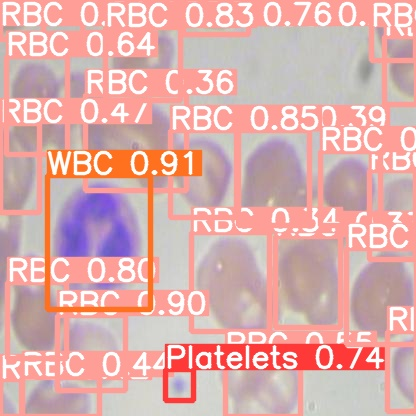

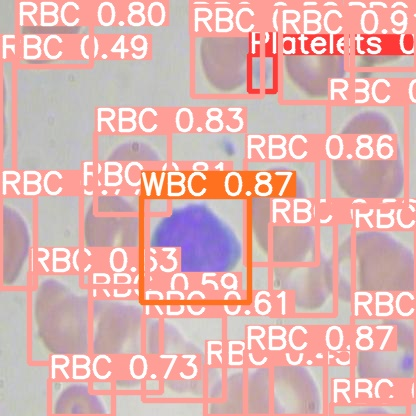

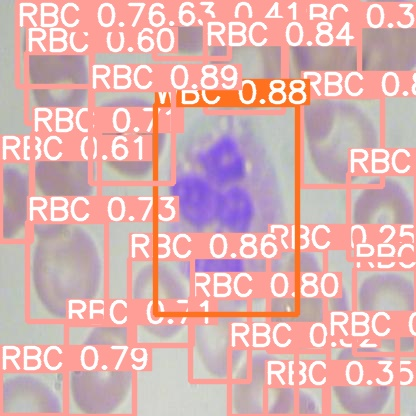

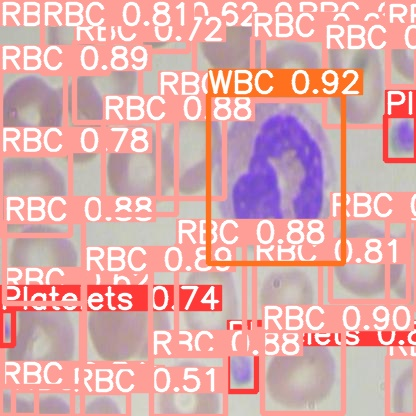

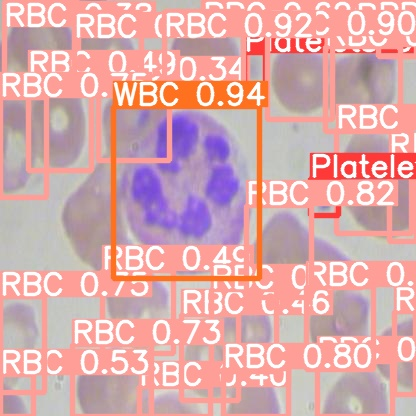

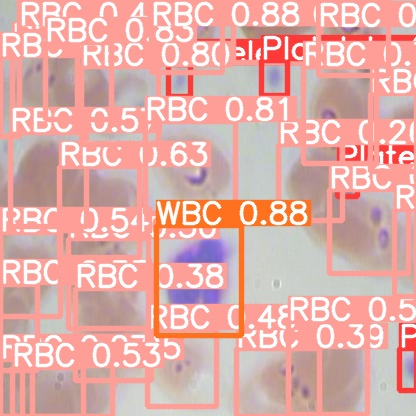

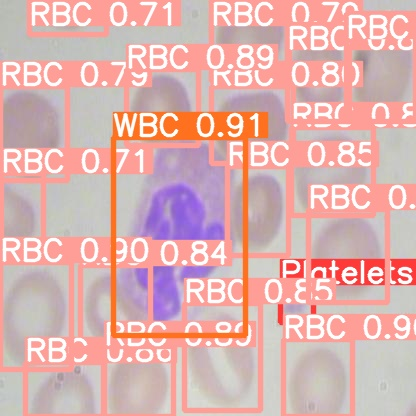

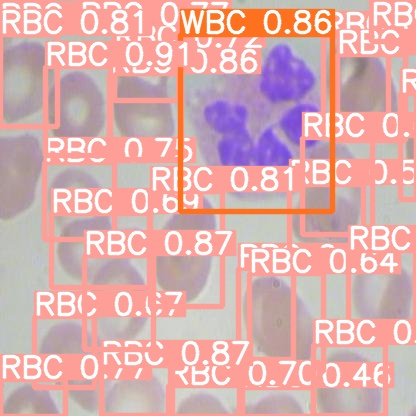

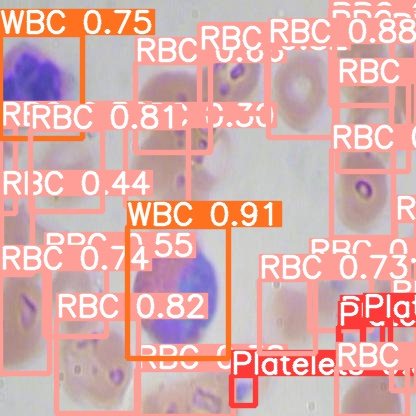

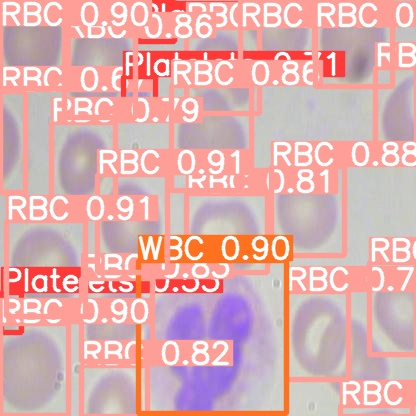

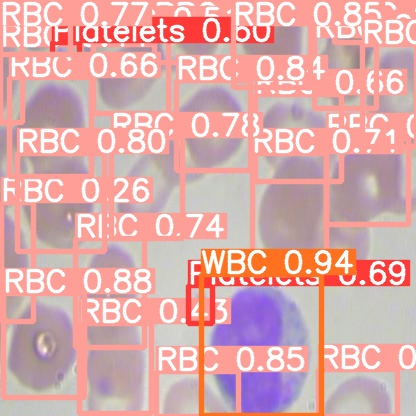

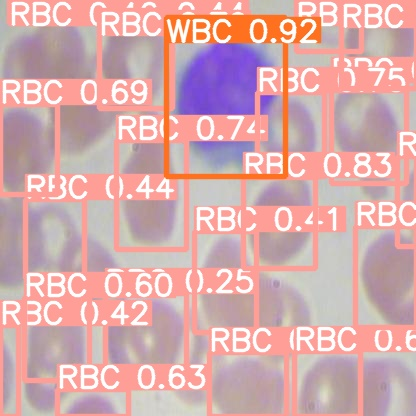

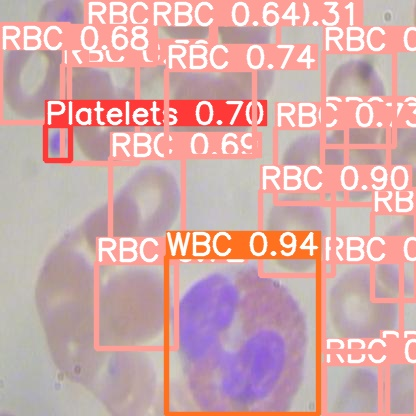

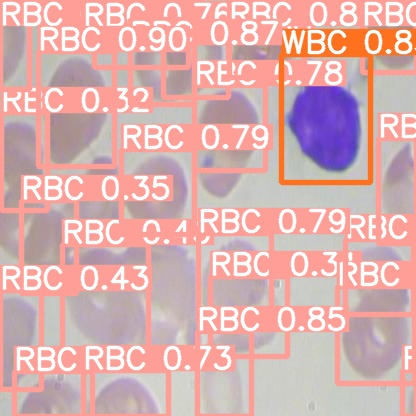

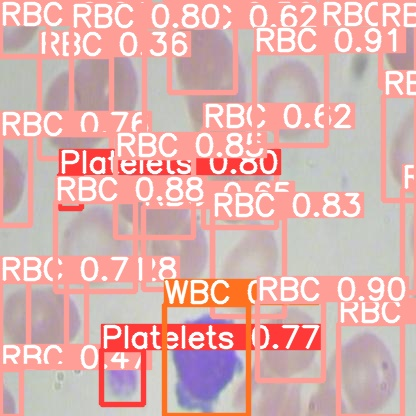

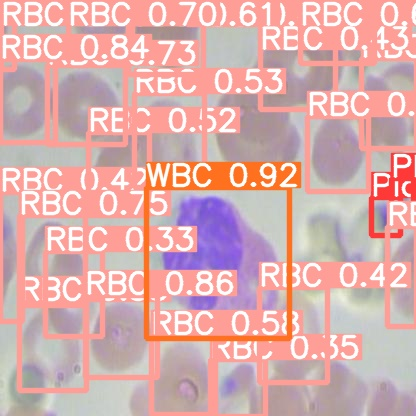

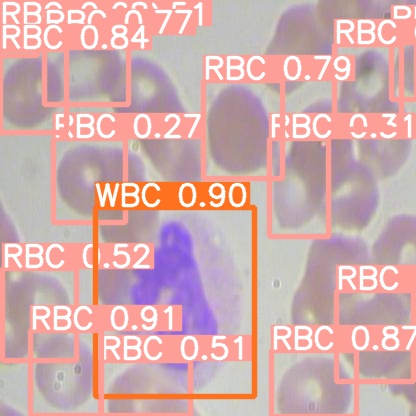

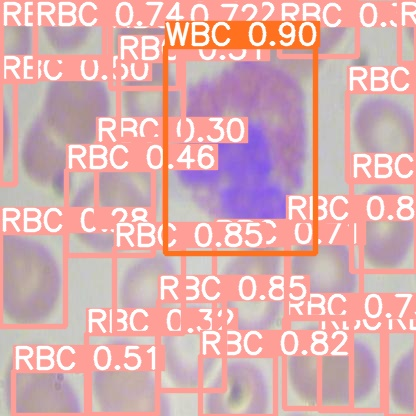

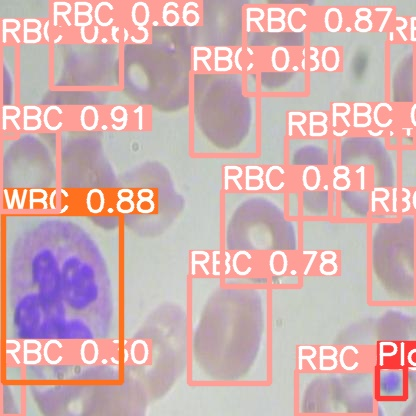

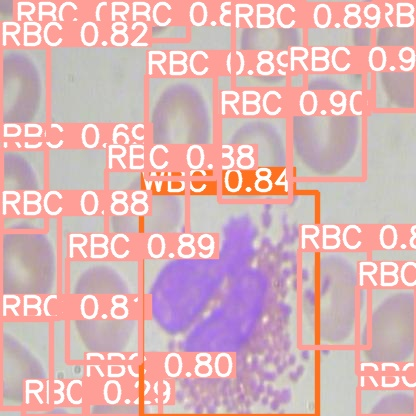

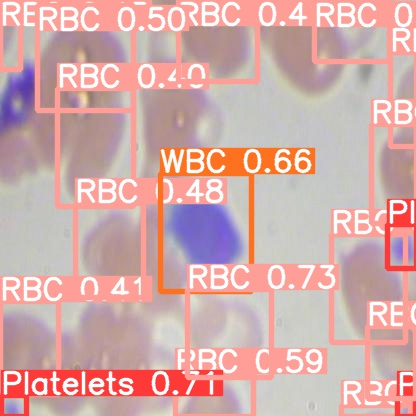

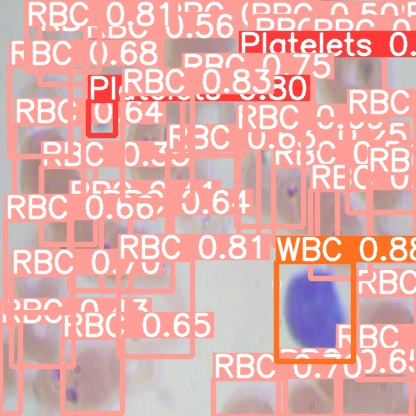

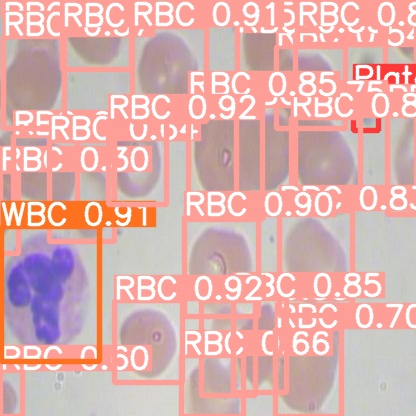

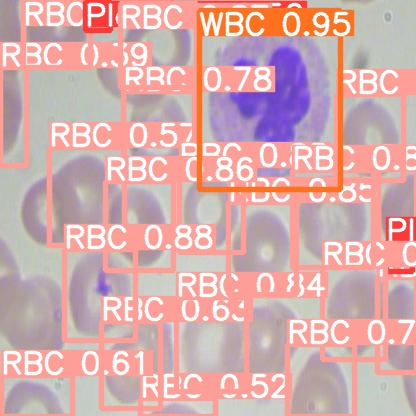

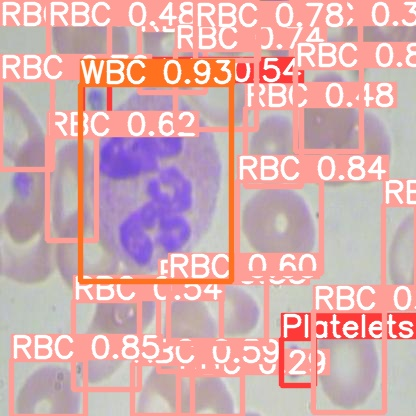

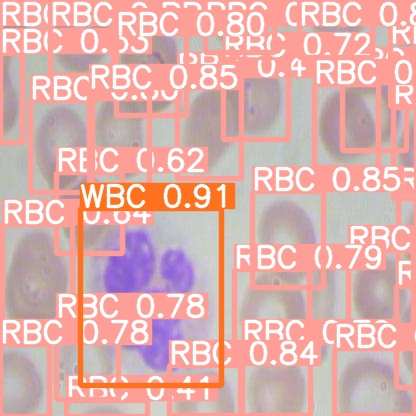

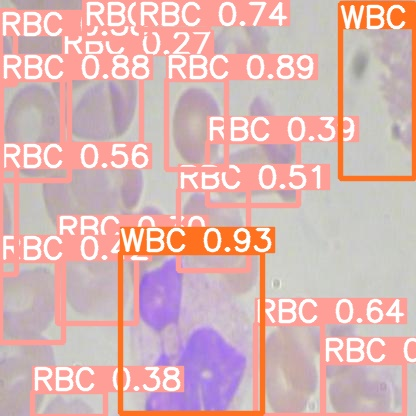

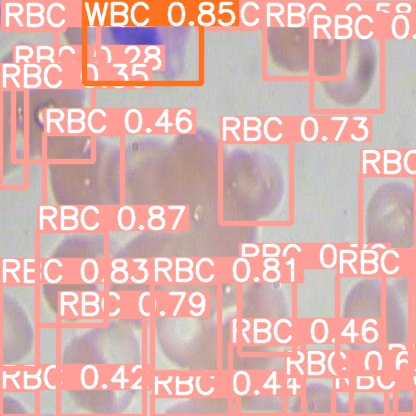

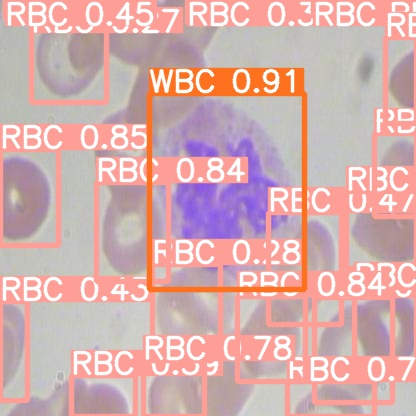

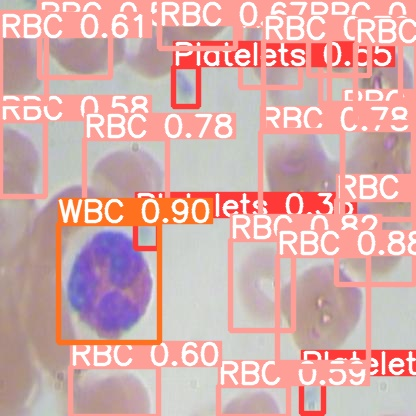

In [21]:
# 検出結果の画像を確認してみましょう。
import glob
from IPython.display import Image as iImage
from IPython.display import display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
    display(iImage(filename=imageName))
    print("\n")